<a href="https://colab.research.google.com/github/probml/boljax/blob/main/boljax/kalman/demos/diagonal_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demos of Diagonal Approximations of EKF

# 0. Imports

In [1]:
try:
    from dynamax.generalized_gaussian_ssm.inference import *
    from dynamax.generalized_gaussian_ssm.models import ParamsGGSSM
    import chex
    import flax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -qq dynamax
    print('installing chex')
    %pip install chex
    print('installing flax')
    %pip install flax
    from dynamax.generalized_gaussian_ssm.inference import *
    from dynamax.generalized_gaussian_ssm.models import ParamsGGSSM
    import chex
    import flax

installing dynamax
     |████████████████████████████████| 121 kB 9.9 MB/s 
     |████████████████████████████████| 154 kB 14.4 MB/s 
     |████████████████████████████████| 85 kB 1.1 MB/s 
installing chex
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
installing flax
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 189 kB 15.3 MB/s 
     |████████████████████████████████| 237 kB 64.5 MB/s 
     |████████████████████████████████| 8.3 MB 26.0 MB/s 
     |████████████████████████████████| 51 kB 6.9 MB/s 


In [164]:
from typing import Sequence
from functools import partial

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import lax
from jax import jacfwd
from jax import vmap
from jax.tree_util import tree_map, tree_reduce
import flax.linen as nn
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalDiag as MVND
import chex
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from jax.flatten_util import ravel_pytree
import optax

from sklearn import datasets
from sklearn import preprocessing

In [3]:
from jax import jacrev

# Copied from private repo boljax
_get_params = lambda x, dim, t: x[t] if x.ndim == dim + 1 else x
_process_fn = lambda f, u: (lambda x, y: f(x)) if u is None else f
_process_input = lambda x, y: jnp.zeros((y,)) if x is None else x
_jacrev_2d = lambda f, x: jnp.atleast_2d(jacrev(f)(x))

@chex.dataclass
class DEKFParams:
    """
    Lightweight container for diagonal EKF Parameters.
    """
    initial_mean: chex.Array
    initial_cov_diag: chex.Array
    dynamics_cov_diag: chex.Array
    emission_mean_function: Callable
    emission_cov_function: Callable


#### Fully decoupled
def _stationary_dynamics_diagonal_predict(m, P_diag, Q_diag):
    """Predict the next state using a stationary dynamics model with diagonal covariance matrices.

    Args:
        m (D_hid,): Prior mean.
        P_diag (D_hid,): Diagonal elements of prior covariance.
        Q_diag (D_hid,): Diagonal elements of dynamics covariance.

    Returns:
        mu_pred (D_hid,): Predicted mean.
        Sigma_pred (D_hid,): Predicted covariance diagonal elements.
    """
    mu_pred = m
    Sigma_pred = P_diag + Q_diag
    return mu_pred, Sigma_pred


def _fully_decoupled_ekf_condition_on(m, P_diag, y_cond_mean, y_cond_cov, u, y, num_iter):
    """Condition on the emission using a fully decoupled EKF.

    Args:
        m (D_hid,): Prior mean.
        P_diag (D_hid,): Diagonal elements of prior covariance.
        y_cond_mean (Callable): Conditional emission mean function.
        y_cond_cov (Callable): Conditional emission covariance function.
        u (D_in,): Control input.
        y (D_obs,): Emission.
        num_iter (int): Number of re-linearizations around posterior.

    Returns:
        mu_cond (D_hid,): Posterior mean.
        Sigma_cond (D_hid,): Posterior covariance diagonal elements.
    """    
    m_Y = lambda x: y_cond_mean(x, u)
    Cov_Y = lambda x: y_cond_cov(x, u)

    def _step(carry, _):
        prior_mean, prior_cov = carry
        yhat = jnp.atleast_1d(m_Y(prior_mean))
        R = jnp.atleast_2d(Cov_Y(prior_mean))
        H =  _jacrev_2d(m_Y, prior_mean)
        S = R + (vmap(lambda hh, pp: pp * jnp.outer(hh, hh), (1, 0))(H, prior_cov)).sum(axis=0)
        K = prior_cov[:, None] * jnp.linalg.lstsq(S.T, H)[0].T
        posterior_mean = prior_mean + K @ (y - yhat)
        posterior_cov = prior_cov - prior_cov * vmap(lambda kk, hh: kk @ hh, (0, 1))(K, H)
        return (posterior_mean, posterior_cov), _

    # Iterate re-linearization over posterior mean and covariance
    carry = (m, P_diag)
    (mu_cond, Sigma_cond), _ = lax.scan(_step, carry, jnp.arange(num_iter))
    return mu_cond, Sigma_cond

def stationary_dynamics_fully_decoupled_conditional_moments_gaussian_filter(model_params, emissions, num_iter=1, inputs=None):
    """Run a fully decoupled EKF on a stationary dynamics model.

    Args:
        model_params (DEKFParams): Model parameters.
        emissions (T, D_hid): Sequence of emissions.
        num_iter (int, optional): Number of linearizations around posterior for update step.
        inputs (T, D_in, optional): Array of inputs.

    Returns:
        filtered_posterior: GSSMPosterior instance containing,
            filtered_means (T, D_hid)
            filtered_covariances (T, D_hid, D_hid)
    """    
    num_timesteps = len(emissions)

    # Process conditional emission moments to take in control inputs
    m_Y, Cov_Y = model_params.emission_mean_function, model_params.emission_cov_function
    m_Y, Cov_Y  = (_process_fn(fn, inputs) for fn in (m_Y, Cov_Y))
    inputs = _process_input(inputs, num_timesteps)

    def _step(carry, t):
        pred_mean, pred_cov_diag = carry

        # Get parameters and inputs for time index t
        Q_diag = _get_params(model_params.dynamics_cov_diag, 1, t)
        u = inputs[t]
        y = emissions[t]

        # Condition on the emission
        filtered_mean, filtered_cov_diag = _fully_decoupled_ekf_condition_on(pred_mean, pred_cov_diag, m_Y, Cov_Y, u, y, num_iter)

        # Predict the next state
        pred_mean, pred_cov_diag = _stationary_dynamics_diagonal_predict(filtered_mean, filtered_cov_diag, Q_diag)

        return (pred_mean, pred_cov_diag), (filtered_mean, filtered_cov_diag)

    # Run the general linearization filter
    carry = (model_params.initial_mean, model_params.initial_cov_diag)
    _, (filtered_means, filtered_covs) = lax.scan(_step, carry, jnp.arange(num_timesteps))
    return PosteriorGSSMFiltered(marginal_loglik=None, filtered_means=filtered_means, filtered_covariances=filtered_covs)


### Variational diagonal
def _variational_diagonal_ekf_condition_on(m, P_diag, y_cond_mean, y_cond_cov, u, y, num_iter):
    """Condition on the emission using a variational diagonal EKF.

    Args:
        m (D_hid,): Prior mean.
        P_diag (D_hid,): Diagonal elements of prior covariance.
        y_cond_mean (Callable): Conditional emission mean function.
        y_cond_cov (Callable): Conditional emission covariance function.
        u (D_in,): Control input.
        y (D_obs,): Emission.
        num_iter (int): Number of re-linearizations around posterior.

    Returns:
        mu_cond (D_hid,): Posterior mean.
        Sigma_cond (D_hid,): Posterior covariance diagonal elements.
    """    
    m_Y = lambda x: y_cond_mean(x, u)
    Cov_Y = lambda x: y_cond_cov(x, u)

    def _step(carry, _):
        prior_mean, prior_cov = carry
        yhat = jnp.atleast_1d(m_Y(prior_mean))
        R = jnp.atleast_2d(Cov_Y(prior_mean))
        H =  _jacrev_2d(m_Y, prior_mean)
        R_inv = jnp.linalg.lstsq(R, jnp.eye(R.shape[0]))[0]
        posterior_cov = 1/(1/prior_cov + ((H.T @ R_inv) * H.T).sum(-1))
        posterior_mean = prior_mean + (posterior_cov * H).T @ R_inv @ (y - yhat)
        # posterior_mean = prior_mean + jnp.diag(posterior_cov) @ H.T @ R_inv @ (y - yhat)
        return (posterior_mean, posterior_cov), _

    # Iterate re-linearization over posterior mean and covariance
    carry = (m, P_diag)
    (mu_cond, Sigma_cond), _ = lax.scan(_step, carry, jnp.arange(num_iter))
    return mu_cond, Sigma_cond

def stationary_dynamics_variational_diagonal_extended_kalman_filter(model_params, emissions, num_iter=1, inputs=None):
    """Run a variational diagonal EKF on a stationary dynamics model.

    Args:
        model_params (DEKFParams): Model parameters.
        emissions (T, D_hid): Sequence of emissions.
        num_iter (int, optional): Number of linearizations around posterior for update step.
        inputs (T, D_in, optional): Array of inputs.

    Returns:
        filtered_posterior: GSSMPosterior instance containing,
            filtered_means (T, D_hid)
            filtered_covariances (T, D_hid, D_hid)
    """    
    num_timesteps = len(emissions)

    # Process conditional emission moments to take in control inputs
    m_Y, Cov_Y = model_params.emission_mean_function, model_params.emission_cov_function
    m_Y, Cov_Y  = (_process_fn(fn, inputs) for fn in (m_Y, Cov_Y))
    inputs = _process_input(inputs, num_timesteps)

    def _step(carry, t):
        pred_mean, pred_cov_diag = carry

        # Get parameters and inputs for time index t
        Q_diag = _get_params(model_params.dynamics_cov_diag, 1, t)
        u = inputs[t]
        y = emissions[t]

        # Condition on the emission
        filtered_mean, filtered_cov_diag = _variational_diagonal_ekf_condition_on(pred_mean, pred_cov_diag, m_Y, Cov_Y, u, y, num_iter)

        # Predict the next state
        pred_mean, pred_cov_diag = _stationary_dynamics_diagonal_predict(filtered_mean, filtered_cov_diag, Q_diag)

        return (pred_mean, pred_cov_diag), (filtered_mean, filtered_cov_diag)

    # Run the general linearization filter
    carry = (model_params.initial_mean, model_params.initial_cov_diag)
    _, (filtered_means, filtered_covs) = lax.scan(_step, carry, jnp.arange(num_timesteps))
    return PosteriorGSSMFiltered(marginal_loglik=None, filtered_means=filtered_means, filtered_covariances=filtered_covs)

# 1. MLP Definition

In [4]:
class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.relu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

def get_mlp_flattened_params(model_dims, key=0):
    """Generate MLP model, initialize it using dummy input, and
    return the model, its flattened initial parameters, function
    to unflatten parameters, and apply function for the model.
    Args:
        model_dims (List): List of [input_dim, hidden_dim, ..., output_dim]
        key (PRNGKey): Random key. Defaults to 0.
    Returns:
        model: MLP model with given feature dimensions.
        flat_params: Flattened parameters initialized using dummy input.
        unflatten_fn: Function to unflatten parameters.
        apply_fn: fn(flat_params, x) that returns the result of applying the model.
    """
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    # Define MLP model
    input_dim, features = model_dims[0], model_dims[1:]
    model = MLP(features)
    dummy_input = jnp.ones((input_dim,))

    # Initialize parameters using dummy input
    params = model.init(key, dummy_input)
    flat_params, unflatten_fn = ravel_pytree(params)

    # Define apply function
    def apply(flat_params, x, model, unflatten_fn):
        return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

    apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)

    return model, flat_params, unflatten_fn, apply_fn

# 2. Demo - Linear Regression

## 2.1 Dataset Generation

In [5]:
def generate_linreg_dataset(num_points=100, theta=jnp.array([1, 0.5]), var=0.1, key=1, shuffle=True):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jr.split(key)
    X = jnp.linspace(0.0, 1.0, num_points)
    Y_tr = theta[1]*X + theta[0]
    noise = var*jr.normal(key, shape=(num_points,))
    Y = Y_tr + noise
    X_sh, Y_sh = X, Y
    # Shuffle data
    if shuffle:
        shuffle_idx = jr.permutation(subkey, jnp.arange(num_points))
        X_sh, Y_sh = X[shuffle_idx], Y[shuffle_idx]

    return X, X_sh, Y, Y_sh, Y_tr

In [6]:
# 100 data points
X_lr_100, X_lr_100_sh, Y_lr_100, Y_lr_100_sh, Y_lr_100_tr = generate_linreg_dataset()

# 200 data points
X_lr_200, X_lr_200_sh, Y_lr_200, Y_lr_200_sh, Y_lr_200_tr = generate_linreg_dataset(200)

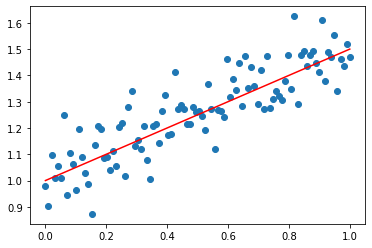

In [7]:
plt.scatter(X_lr_100, Y_lr_100)
plt.plot(X_lr_100, Y_lr_100_tr, c='red');

In [8]:
# Define Linear Regression as single layer perceptron
input_dim_lr, hidden_dims_lr, output_dim_lr = 1, [], 1
model_dims_lr = [input_dim_lr, *hidden_dims_lr, output_dim_lr]
_, flat_params_lr, _, apply_fn_lr = get_mlp_flattened_params(model_dims_lr)
print(flat_params_lr.shape)

(2,)


## 2.2 Full-Covariance CMGF-EKF

In [9]:
# FC-EKF for linear regression
state_dim_lr, emission_dim_lr = flat_params_lr.size, output_dim_lr
var_lr = 0.1
fcekf_params_lr = ParamsGGSSM(
    initial_mean=flat_params_lr,
    initial_covariance=jnp.eye(state_dim_lr),
    dynamics_function=lambda w, _: w,
    dynamics_covariance = jnp.eye(state_dim_lr) * 0,
    emission_mean_function = lambda w, x: apply_fn_lr(w, x),
    emission_cov_function = lambda w, x: var_lr
)
v_apply_fn_lr = vmap(apply_fn_lr, (None, 0))

fcekf_theta_lr_100 = [1.0154614 0.4900457]


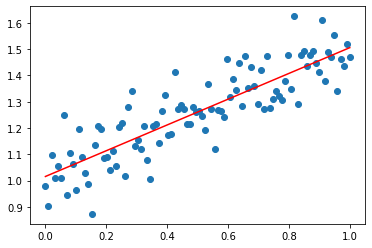

In [10]:
# 100 datapoints
fcekf_post_lr_100 = conditional_moments_gaussian_filter(fcekf_params_lr, EKFIntegrals(), Y_lr_100_sh, inputs=X_lr_100_sh)
fcekf_theta_lr_100 = fcekf_post_lr_100.filtered_means[-1]
print(f'fcekf_theta_lr_100 = {fcekf_theta_lr_100}')
plt.scatter(X_lr_100, Y_lr_100)
plt.plot(X_lr_100, v_apply_fn_lr(fcekf_theta_lr_100, X_lr_100), c='red');

fcekf_theta_lr_200 = [1.0101917  0.48369387]


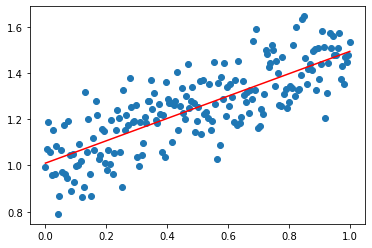

In [11]:
# 200 datapoints
fcekf_post_lr_200 = conditional_moments_gaussian_filter(fcekf_params_lr, EKFIntegrals(), Y_lr_200_sh, inputs=X_lr_200_sh)
fcekf_theta_lr_200 = fcekf_post_lr_200.filtered_means[-1]
print(f'fcekf_theta_lr_200 = {fcekf_theta_lr_200}')
plt.scatter(X_lr_200, Y_lr_200)
plt.plot(X_lr_200, v_apply_fn_lr(fcekf_theta_lr_200, X_lr_200), c='red');

## 2.3 Fully-Decoupled Diagonal EKF

In [12]:
# D-EKF for linear regression
dekf_params_lr = DEKFParams(
    initial_mean=flat_params_lr,
    initial_cov_diag=jnp.ones((state_dim_lr,)),
    dynamics_cov_diag=jnp.ones((state_dim_lr,)) * 0,
    emission_mean_function = lambda w, x: apply_fn_lr(w, x),
    emission_cov_function = lambda w, x: var_lr
)

fdekf_theta_lr_100 = [1.0655402  0.42434162]


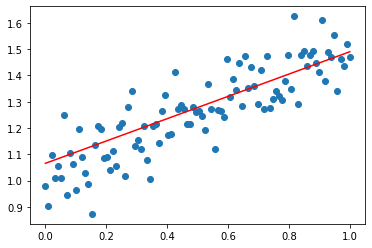

In [13]:
# 100 datapoints
fdekf_post_lr_100 = stationary_dynamics_fully_decoupled_conditional_moments_gaussian_filter(dekf_params_lr, Y_lr_100, inputs=X_lr_100)
fdekf_theta_lr_100 = fdekf_post_lr_100.filtered_means[-1]
print(f'fdekf_theta_lr_100 = {fdekf_theta_lr_100}')
plt.scatter(X_lr_100, Y_lr_100)
plt.plot(X_lr_100, v_apply_fn_lr(fdekf_theta_lr_100, X_lr_100), c='red');

fdekf_theta_lr_200 = [1.0710174  0.40271682]


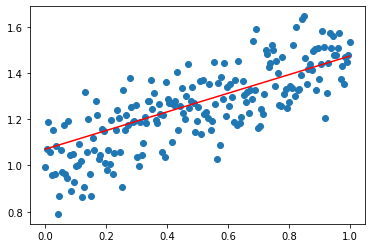

In [14]:
# 200 datapoints
fdekf_post_lr_200 = stationary_dynamics_fully_decoupled_conditional_moments_gaussian_filter(dekf_params_lr, Y_lr_200, inputs=X_lr_200)
fdekf_theta_lr_200 = fdekf_post_lr_200.filtered_means[-1]
print(f'fdekf_theta_lr_200 = {fdekf_theta_lr_200}')
plt.scatter(X_lr_200, Y_lr_200)
plt.plot(X_lr_200, v_apply_fn_lr(fdekf_theta_lr_200, X_lr_200), c='red');

## 2.4 Variational Diagonal EKF

vdekf_theta_lr_100 = [1.0622964  0.42842963]


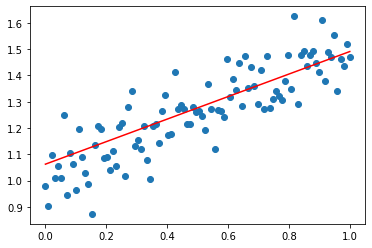

In [15]:
# 100 datapoints
vdekf_post_lr_100 = stationary_dynamics_variational_diagonal_extended_kalman_filter(dekf_params_lr, Y_lr_100, inputs=X_lr_100)
vdekf_theta_lr_100 = vdekf_post_lr_100.filtered_means[-1]
print(f'vdekf_theta_lr_100 = {vdekf_theta_lr_100}')
plt.scatter(X_lr_100, Y_lr_100)
plt.plot(X_lr_100, v_apply_fn_lr(vdekf_theta_lr_100, X_lr_100), c='red');

vdekf_theta_lr_200 = [1.0714711  0.40201488]


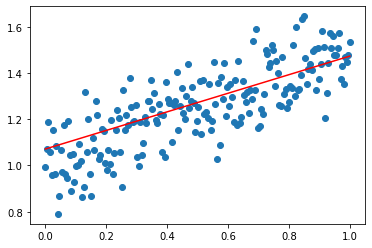

In [16]:
# 200 datapoints
vdekf_post_lr_200 = stationary_dynamics_variational_diagonal_extended_kalman_filter(dekf_params_lr, Y_lr_200, inputs=X_lr_200)
vdekf_theta_lr_200 = vdekf_post_lr_200.filtered_means[-1]
print(f'vdekf_theta_lr_200 = {vdekf_theta_lr_200}')
plt.scatter(X_lr_200, Y_lr_200)
plt.plot(X_lr_200, v_apply_fn_lr(vdekf_theta_lr_200, X_lr_200), c='red');

## 2.5 SGD - Single Pass

In [17]:
# Generic loss function
def loss_optax(params, x, y, loss_fn, apply_fn):
    y, y_hat = jnp.atleast_1d(y), apply_fn(params, x)
    loss_value = loss_fn(y, y_hat)
    return loss_value.mean()

In [18]:
# SGD fit function
def fit_optax(params, optimizer, input, output, loss_fn, num_epochs=200):
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state, x, y):
        loss_value, grads = jax.value_and_grad(loss_fn)(params, x, y)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    for epoch in range(num_epochs):
        for i, (x, y) in enumerate(zip(input, output)):
            params, opt_state, loss_value = step(params, opt_state, x, y)
    
    return params

# Define SGD optimizer
sgd_optimizer = optax.sgd(learning_rate=1e-2)

In [19]:
# L2 loss function for linear regression
loss_fn_lr = partial(loss_optax, loss_fn = optax.l2_loss, apply_fn = apply_fn_lr)

sgd_sp_theta_lr_100 = [0.78413326 0.24538855]


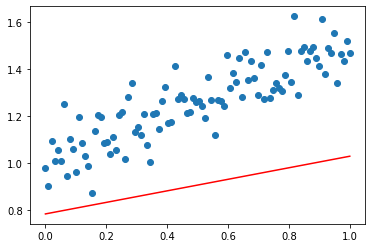

In [20]:
# 100 datapoints
sgd_sp_theta_lr_100 = fit_optax(flat_params_lr, sgd_optimizer, X_lr_100, Y_lr_100, loss_fn_lr, num_epochs=1)
print(f'sgd_sp_theta_lr_100 = {sgd_sp_theta_lr_100}')
plt.scatter(X_lr_100, Y_lr_100)
plt.plot(X_lr_100, v_apply_fn_lr(sgd_sp_theta_lr_100, X_lr_100), c='red');

sgd_sp_theta_lr_100 = [1.0464454 0.28149  ]


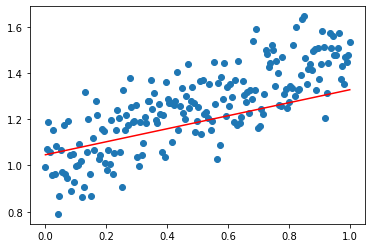

In [21]:
# 200 datapoints
sgd_sp_theta_lr_200 = fit_optax(flat_params_lr, sgd_optimizer, X_lr_200, Y_lr_200, loss_fn_lr, num_epochs=1)
print(f'sgd_sp_theta_lr_100 = {sgd_sp_theta_lr_200}')
plt.scatter(X_lr_200, Y_lr_200)
plt.plot(X_lr_200, v_apply_fn_lr(sgd_sp_theta_lr_200, X_lr_200), c='red');

## 2.6 SGD - Multi Pass (200 Epochs)

sgd_mp_theta_lr_100 = [1.0177511  0.48671076]


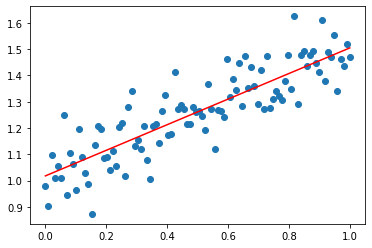

In [22]:
# 100 datapoints
sgd_mp_theta_lr_100 = fit_optax(flat_params_lr, sgd_optimizer, X_lr_100, Y_lr_100, loss_fn_lr)
print(f'sgd_mp_theta_lr_100 = {sgd_mp_theta_lr_100}')
plt.scatter(X_lr_100, Y_lr_100)
plt.plot(X_lr_100, v_apply_fn_lr(sgd_mp_theta_lr_100, X_lr_100), c='red');

sgd_mp_theta_lr_200 = [1.0130811  0.47778532]


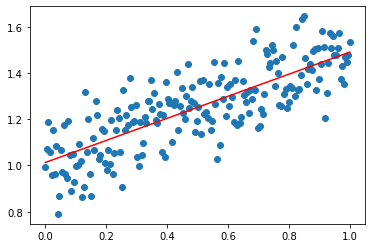

In [23]:
# 200 datapoints
sgd_mp_theta_lr_200 = fit_optax(flat_params_lr, sgd_optimizer, X_lr_200, Y_lr_200, loss_fn_lr)
print(f'sgd_mp_theta_lr_200 = {sgd_mp_theta_lr_200}')
plt.scatter(X_lr_200, Y_lr_200)
plt.plot(X_lr_200, v_apply_fn_lr(sgd_mp_theta_lr_200, X_lr_200), c='red');

# 3. Demo - Nonlinear Regression

## 3.1 Dataset Generation

In [24]:
def generate_nonlinreg_dataset(num_points=400, fn=lambda x: jnp.sin(5*x**2 - 1), var=0.1, key=1, shuffle=True):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jr.split(key)
    X = jnp.linspace(0.0, 1.0, num_points)
    Y_tr = vmap(fn)(X)
    noise = var*jr.normal(key, shape=(num_points,))
    Y = Y_tr + noise
    X_sh, Y_sh = X, Y
    
    # Shuffle data
    if shuffle:
        shuffle_idx = jr.permutation(subkey, jnp.arange(num_points))
        X_sh, Y_sh = X[shuffle_idx], Y[shuffle_idx]
    return X, X_sh, Y, Y_sh, Y_tr

In [25]:
X_nr, X_nr_sh, Y_nr, Y_nr_sh, Y_nr_tr = generate_nonlinreg_dataset()

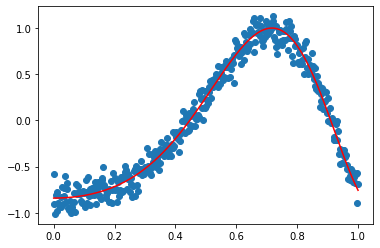

In [26]:
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, Y_nr_tr, c='red');

In [27]:
# Define Linear Regression as MLP with one hidden layer
input_dim_nr, hidden_dims_nr, output_dim_nr = 1, [15, 15], 1
model_dims_nr = [input_dim_nr, *hidden_dims_nr, output_dim_nr]
_, flat_params_nr, _, apply_fn_nr = get_mlp_flattened_params(model_dims_nr)
print(flat_params_nr.shape)

(286,)


## 3.2 Full-Covariance CMGF-EKF

In [28]:
# FC-EKF for nonlinear regression
state_dim_nr, emission_dim_nr = flat_params_nr.size, output_dim_nr
var_nr = 0.1
fcekf_params_nr = ParamsGGSSM(
    initial_mean=flat_params_nr,
    initial_covariance=jnp.eye(state_dim_nr),
    dynamics_function=lambda w, _: w,
    dynamics_covariance = jnp.eye(state_dim_nr) * 0,
    emission_mean_function = lambda w, x: apply_fn_nr(w, x),
    emission_cov_function = lambda w, x: var_nr
)
v_apply_fn_nr = vmap(apply_fn_nr, (None, 0))

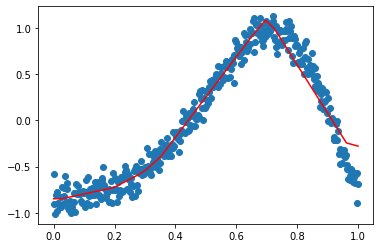

In [29]:
fcekf_post_nr = conditional_moments_gaussian_filter(fcekf_params_nr, EKFIntegrals(), Y_nr_sh, inputs=X_nr_sh)
fcekf_weight_nr = fcekf_post_nr.filtered_means[-1]
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, v_apply_fn_nr(fcekf_weight_nr, X_nr), c='red');

## 3.3 Fully-Decoupled Diagonal EKF

In [30]:
# D-EKF for nonlinear regression
dekf_params_nr = DEKFParams(
    initial_mean=flat_params_nr,
    initial_cov_diag=jnp.ones((state_dim_nr,)),
    dynamics_cov_diag=jnp.ones((state_dim_nr,)) * 0,
    emission_mean_function = lambda w, x: apply_fn_nr(w, x),
    emission_cov_function = lambda w, x: var_nr
)

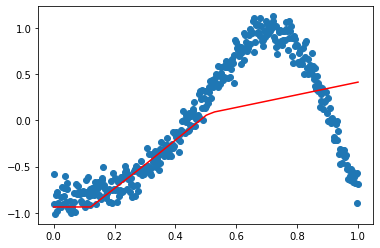

In [31]:
fdekf_post_nr = stationary_dynamics_fully_decoupled_conditional_moments_gaussian_filter(dekf_params_nr, Y_nr_sh, inputs=X_nr_sh)
fdekf_weight_nr = fdekf_post_nr.filtered_means[-1]
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, v_apply_fn_nr(fdekf_weight_nr, X_nr), c='red');

## 3.4 Variational Diagonal EKF

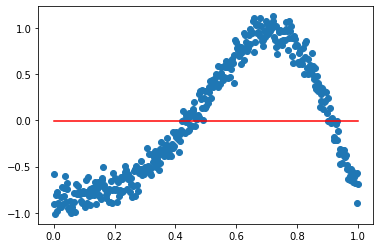

In [32]:
vdekf_post_nr = stationary_dynamics_variational_diagonal_extended_kalman_filter(dekf_params_nr, Y_nr_sh, inputs=X_nr_sh)
vdekf_weight_nr = vdekf_post_nr.filtered_means[-1]
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, v_apply_fn_nr(vdekf_weight_nr, X_nr), c='red');

## 3.5 SGD - Single Pass

In [33]:
# L2 loss function for nonlinear regression
loss_fn_nr = partial(loss_optax, loss_fn = optax.l2_loss, apply_fn = apply_fn_nr)

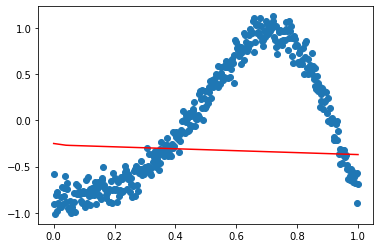

In [34]:
sgd_sp_nr = fit_optax(flat_params_nr, sgd_optimizer, X_nr, Y_nr, loss_fn_nr, num_epochs=1)
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, v_apply_fn_nr(sgd_sp_nr, X_nr), c='red');

## 3.6 SGD - Multi Pass (200 Epochs)

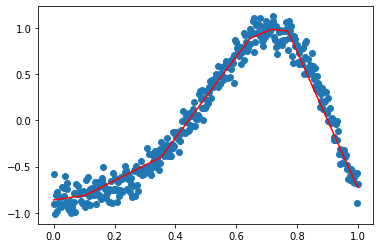

In [35]:
sgd_mp_nr = fit_optax(flat_params_nr, sgd_optimizer, X_nr, Y_nr, loss_fn_nr, num_epochs=200)
plt.scatter(X_nr, Y_nr)
plt.plot(X_nr, v_apply_fn_nr(sgd_mp_nr, X_nr), c='red');

# 4. Demo - Linearly-Separable Classification

## 4.1 Dataset Generation

In [36]:
def generate_input_grid(input):
    """Generate grid on input space.
    Args:
        input (DeviceArray): Input array to determine the range of the grid.
    Returns:
        input_grid: Generated input grid.
    """    
    # Define grid limits
    xmin, ymin = input.min(axis=0) - 0.1
    xmax, ymax = input.max(axis=0) + 0.1

    # Define grid
    step = 0.1
    x_grid, y_grid = jnp.meshgrid(jnp.mgrid[xmin:xmax:step], jnp.mgrid[ymin:ymax:step])
    input_grid = jnp.concatenate([x_grid[...,None], y_grid[...,None]], axis=2)

    return input_grid

In [185]:
def posterior_predictive_grid_ekf(grid, mean, cov, apply, binary=False, ekf_type='fcekf', 
                                  num_samples=100,key=0):
    """Compute posterior predictive probability for each point in grid
    Args:
        grid (DeviceArray): Grid on which to predict posterior probability.
        mean (DeviceArray): Posterior mean of parameters.
        cov (DeviceArray): Posterior cov of parameters.
        apply (Callable): Apply function for MLP.
        binary (bool, optional): Flag to determine whether to round probabilities to binary outputs. Defaults to True.
    Returns:
        _type_: _description_
    """
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    if ekf_type == 'fcekf':
        mvn = MVN(loc=mean, covariance_matrix=cov)
    else:
        mvn = MVND(loc=mean, scale_diag=cov)
    # Sample parameters
    sampled_params = mvn.sample(seed=key, sample_shape=num_samples)
    
    def posterior_predictive_single_param(param):
        inferred_fn = lambda x: apply(param, x)
        fn_vec = jnp.vectorize(inferred_fn, signature='(2)->(3)')
        Z = fn_vec(grid)
        if binary:
            Z = jnp.rint(Z)
        return Z
    
    Zs = vmap(posterior_predictive_single_param, (0,))(sampled_params)
    return Zs.mean(axis=0)

In [186]:
def posterior_predictive_grid(grid, mean, apply, binary=False):
    """Compute posterior predictive probability for each point in grid
    Args:
        grid (DeviceArray): Grid on which to predict posterior probability.
        mean (DeviceArray): Posterior mean of parameters.
        apply (Callable): Apply function for MLP.
        binary (bool, optional): Flag to determine whether to round probabilities to binary outputs. Defaults to True.
    Returns:
        _type_: _description_
    """    
    inferred_fn = lambda x: apply(mean, x)
    fn_vec = jnp.vectorize(inferred_fn, signature='(2)->(3)')
    Z = fn_vec(grid)
    if binary:
        Z = jnp.rint(Z)
    return Z

In [187]:
def plot_posterior_predictive(ax, X, Y, title, Xspace=None, Zspace=None, cmap=cm.rainbow):
    """Plot the 2d posterior predictive distribution.
    Args:
        ax (axis): Matplotlib axis.
        X (DeviceArray): Input array.
        title (str): Title for the plot.
        colors (list): List of colors that correspond to each element in X.
        Xspace (DeviceArray, optional): Input grid to predict on. Defaults to None.
        Zspace (DeviceArray, optional): Predicted posterior on the input grid. Defaults to None.
        cmap (str, optional): Matplotlib colormap. Defaults to "viridis".
    """    
    if Xspace is not None and Zspace is not None:
        ax.contourf(*(Xspace.T), (Zspace.T[0]), cmap=cmap, levels=50)
        ax.axis('off')
    colors = ['red' if y else 'blue' for y in Y]
    ax.scatter(*X.T, c=colors, edgecolors='black', s=50)
    ax.set_title(title)
    plt.tight_layout()
    return ax

In [188]:
def generate_linearly_separable_dataset(num_per_class=250, key=1):
    X, y = datasets.make_blobs(n_samples=500, centers=2, n_features=2, center_box=(0, 10), random_state=key)
    scaler = preprocessing.StandardScaler()
    X = jnp.array(scaler.fit_transform(X))
    y = jnp.array(y.astype('float'))
    return X, y

In [40]:
X_lc, Y_lc = generate_linearly_separable_dataset()

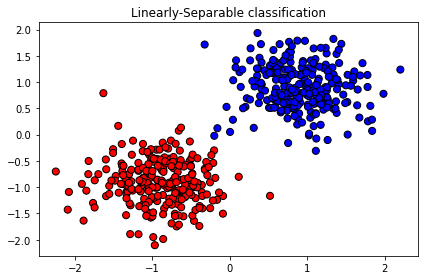

In [41]:
fig, ax = plt.subplots()
plot_posterior_predictive(ax, X_lc, Y_lc, "Linearly-Separable classification");

In [42]:
# MLP for linearly-separable classification
input_dim_lc, hidden_dims_lc, output_dim_lc = 2, [5, 5], 1
model_dims_lc = [input_dim_lc, *hidden_dims_lc, output_dim_lc]
_, flat_params_lc, _, apply_fn_lc = get_mlp_flattened_params(model_dims_lc)
print(flat_params_lc.shape)

(51,)


## 4.2 Full Covariance CMGF-EKF

In [166]:
# CMGF-EKF for MLP Classifier
state_dim_lc, emission_dim_lc = flat_params_lc.size, output_dim_lc
eps_lc = 1e-4
sigmoid_fn_lc = lambda w, x: jnp.clip(jax.nn.sigmoid(apply_fn_lc(w, x)), eps_lc, 1-eps_lc) # Clip to prevent divergence
fcekf_params_lc = ParamsGGSSM(
    initial_mean=flat_params_lc,
    initial_covariance=jnp.eye(state_dim_lc),
    dynamics_function=lambda w, _: w,
    dynamics_covariance = jnp.eye(state_dim_lc) * 0,
    emission_mean_function = lambda w, x: sigmoid_fn_lc(w, x),
    emission_cov_function = lambda w, x: sigmoid_fn_lc(w, x) * (1 - sigmoid_fn_lc(w, x))
)

In [170]:
fcekf_post_lc = conditional_moments_gaussian_filter(fcekf_params_lc, EKFIntegrals(), Y_lc, inputs=X_lc)
fcekf_weight_lc = fcekf_post_lc.filtered_means[-1]
fcekf_cov_lc = fcekf_post_lc.filtered_covariances[-1]

In [ ]:
def posterior_predictive_grid(grid, mean, cov, apply, binary=False, ekf_type='fcekf', 
                              num_samples=100,key=0):

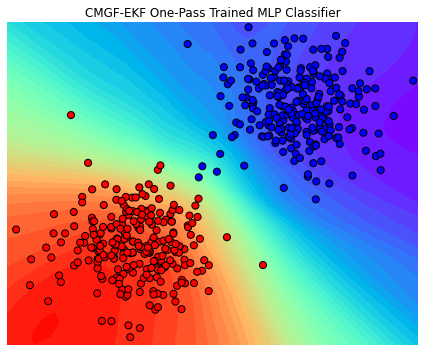

In [189]:
input_grid_lc = generate_input_grid(X_lc)

# Evaluate the trained MLP on grid and plot
Z_fcekf_lc = posterior_predictive_grid_ekf(input_grid_lc, fcekf_weight_lc, fcekf_cov_lc, sigmoid_fn_lc)
fig, ax = plt.subplots(figsize=(6, 5))
title = "CMGF-EKF One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_lc, Y_lc, title, input_grid_lc, Z_fcekf_lc);

## 4.3 Fully-Decoupled Diagonal EKF

In [46]:
dekf_params_lc = DEKFParams(
    initial_mean=flat_params_lc,
    initial_cov_diag=jnp.ones((state_dim_lc,)),
    dynamics_cov_diag=jnp.ones((state_dim_lc,)) * 1e-4,
    emission_mean_function = lambda w, x: sigmoid_fn_lc(w, x),
    emission_cov_function = lambda w, x: sigmoid_fn_lc(w, x) * (1 - sigmoid_fn_lc(w, x))
)

In [179]:
fdekf_post_lc = stationary_dynamics_fully_decoupled_conditional_moments_gaussian_filter(dekf_params_lc, Y_lc, inputs=X_lc)
fdekf_weight_lc = fdekf_post_lc.filtered_means[-1]
fdekf_cov_lc = fdekf_post_lc.filtered_covariances[-1]

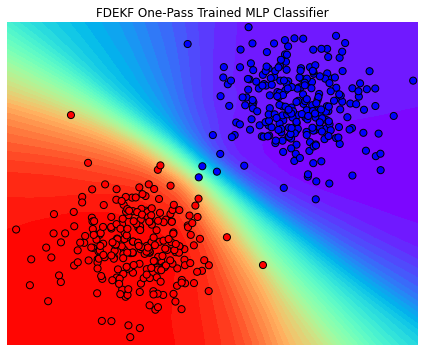

In [190]:
# Evaluate the trained MLP on grid and plot
Z_fdekf_lc = posterior_predictive_grid_ekf(input_grid_lc, fdekf_weight_lc, fdekf_cov_lc, sigmoid_fn_lc, binary=False,
                                       ekf_type='fdekf')
fig, ax = plt.subplots(figsize=(6, 5))
title = "FDEKF One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_lc, Y_lc, title, input_grid_lc, Z_fdekf_lc);

## 4.4 Variational Diagonal EKF

In [182]:
vdekf_post_lc = stationary_dynamics_variational_diagonal_extended_kalman_filter(dekf_params_lc, Y_lc, inputs=X_lc)
vdekf_weight_lc = vdekf_post_lc.filtered_means[-1]
vdekf_cov_lc = vdekf_post_lc.filtered_covariances[-1]

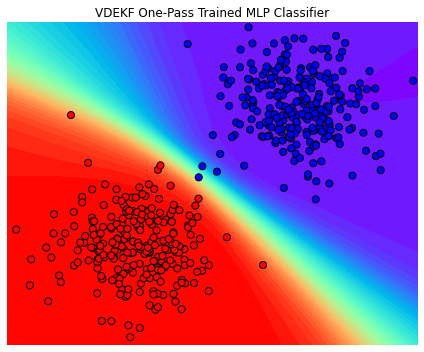

In [191]:
# Evaluate the trained MLP on grid and plot
Z_vdekf_lc = posterior_predictive_grid_ekf(input_grid_lc, vdekf_weight_lc, 
                                       vdekf_cov_lc, sigmoid_fn_lc, binary=False, ekf_type='vdekf')
fig, ax = plt.subplots(figsize=(6, 5))
title = "VDEKF One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_lc, Y_lc, title, input_grid_lc, Z_vdekf_lc);

## 4.5 SGD - Single Pass

In [192]:
# Cross entropy loss for linear classification
loss_fn_lc = partial(loss_optax, loss_fn = lambda y, yhat: -(y * jnp.log(yhat) + (1-y) * jnp.log(1 - yhat)), 
                     apply_fn = sigmoid_fn_lc)

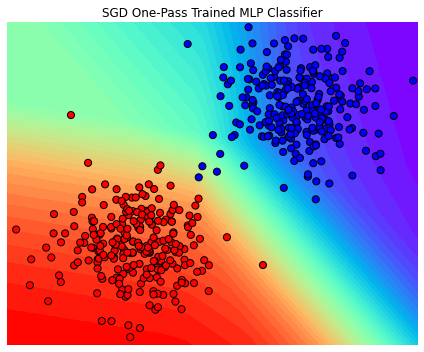

In [193]:
sgd_sp_lc = fit_optax(flat_params_lc, sgd_optimizer, X_lc, Y_lc, loss_fn_lc, num_epochs=1)

# Evaluate the trained MLP on grid and plot
Z_sgd_sp_lc = posterior_predictive_grid(input_grid_lc, sgd_sp_lc, sigmoid_fn_lc, binary=False)
fig, ax = plt.subplots(figsize=(6, 5))
title = "SGD One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_lc, Y_lc, title, input_grid_lc, Z_sgd_sp_lc);

## 4.6 SGD - Multi Pass (200 Epochs)

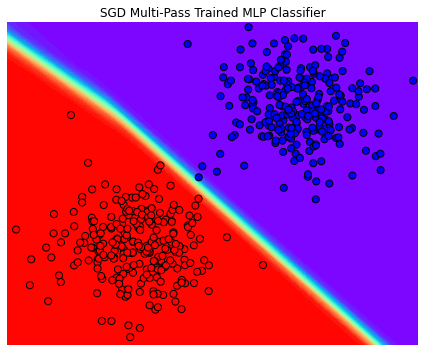

In [53]:
sgd_mp_lc = fit_optax(flat_params_lc, sgd_optimizer, X_lc, Y_lc, loss_fn_lc, num_epochs=200)

# Evaluate the trained MLP on grid and plot
Z_sgd_mp_lc = posterior_predictive_grid(input_grid_lc, sgd_mp_lc, sigmoid_fn_lc, binary=False)
fig, ax = plt.subplots(figsize=(6, 5))
title = "SGD Multi-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_lc, Y_lc, title, input_grid_lc, Z_sgd_mp_lc);

# 5. Demo - Nonlinear Classification

## 5.1 Dataset Generation

In [194]:
def generate_spiral_dataset(num_per_class=250, zero_var=1., one_var=1., shuffle=True, key=0):
    """Generate balanced, standardized 2d "spiral" binary classification dataset.
    Code adapted from https://gist.github.com/45deg/e731d9e7f478de134def5668324c44c5
    Args:
        num_per_class (int, optional): Number of points to generate per class. Defaults to 250.
        zero_val (float, optional): Noise variance for inputs withj label '0'. Defaults to 1.
        one_val (float, optional): Noise variance for inputs withj label '1'. Defaults to 1.
        shuffle (bool, optional): Flag to determine whether to return shuffled dataset. Defaults to True.
        key (int, optional): Initial PRNG seed for jax.random. Defaults to 0.
    Returns:
        input: Generated input.
        output: Generated binary output.
    """    
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key1, key2, key3, key4 = jr.split(key, 4)

    theta = jnp.sqrt(jr.uniform(key1, shape=(num_per_class,))) * 2*jnp.pi
    r = 2*theta + jnp.pi
    generate_data = lambda theta, r: jnp.array([jnp.cos(theta)*r, jnp.sin(theta)*r]).T

    # Input data for output zero
    zero_input = generate_data(theta, r) + zero_var * jr.normal(key2, shape=(num_per_class, 2))

    # Input data for output one
    one_input = generate_data(theta, -r) + one_var * jr.normal(key3, shape=(num_per_class, 2))

    # Stack the inputs and standardize
    input = jnp.concatenate([zero_input, one_input])
    input = (input - input.mean(axis=0)) / input.std(axis=0)

    # Generate binary output
    output = jnp.concatenate([jnp.zeros(num_per_class), jnp.ones(num_per_class)])

    if shuffle:
        idx = jr.permutation(key4, jnp.arange(num_per_class * 2))
        input, output = input[idx], output[idx]

    return input, output

In [195]:
num_per_class=250
X_nc, Y_nc = generate_spiral_dataset(num_per_class)

In [201]:
# Define MLP architecture
input_dim_nc, hidden_dims_nc, output_dim_nc = 2, [25, 25], 1
model_dims_nc = [input_dim_nc, *hidden_dims_nc, output_dim_nc]
_, flat_params_nc, _, apply_fn_nc = get_mlp_flattened_params(model_dims_nc)
print(flat_params_nc.shape)

(751,)


## 5.2 Full Covariance CMGF-EKF

In [202]:
# FCEKF for nonlinear classification
state_dim_nc, emission_dim_nc = flat_params_nc.size, output_dim_nc
eps_nc = 1e-4
sigmoid_fn_nc = lambda w, x: jnp.clip(jax.nn.sigmoid(apply_fn_nc(w, x)), eps_nc, 1-eps_nc) # Clip to prevent divergence
fcekf_params_nc = ParamsGGSSM(
    initial_mean=flat_params_nc,
    initial_covariance=jnp.eye(state_dim_nc),
    dynamics_function=lambda w, _: w,
    dynamics_covariance = jnp.eye(state_dim_nc) * 0,
    emission_mean_function = lambda w, x: sigmoid_fn_nc(w, x),
    emission_cov_function = lambda w, x: sigmoid_fn_nc(w, x) * (1 - sigmoid_fn_nc(w, x))
)
input_grid_nc = generate_input_grid(X_nc)

In [203]:
fcekf_post_nc = conditional_moments_gaussian_filter(fcekf_params_nc, EKFIntegrals(), Y_nc, inputs=X_nc)
fcekf_weights_nc = fcekf_post_nc.filtered_means
fcekf_covs_nc = fcekf_post_nc.filtered_covariances
fcekf_weight_nc = fcekf_weights_nc[-1]
fcekf_cov_nc = fcekf_covs_nc[-1]

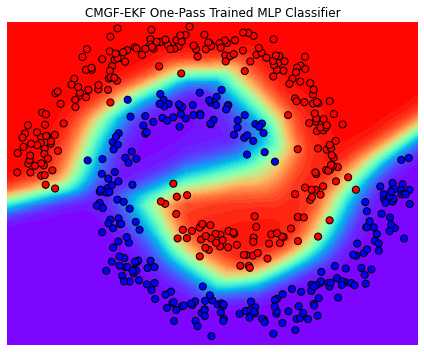

In [233]:
input_grid_nc = generate_input_grid(X_nc)

# Evaluate the trained MLP on grid using MAP "plugin"
Z_fcekf_nc = posterior_predictive_grid(input_grid_nc, fcekf_weight_nc, sigmoid_fn_nc, binary=False)
fig, ax = plt.subplots(figsize=(6, 5))
title = "CMGF-EKF One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_nc, Y_nc, title, input_grid_nc, Z_fcekf_nc);

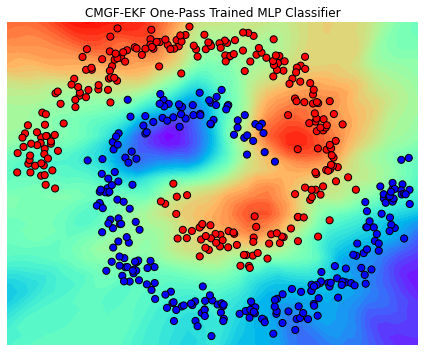

In [234]:
# Laplace-approximation of posterior predictive
Z_fcekf_nc_laplace = posterior_predictive_grid_ekf(input_grid_nc, fcekf_weight_nc,
                                                   fcekf_cov_nc, sigmoid_fn_nc, binary=False,
                                                   ekf_type='fcekf')
fig, ax = plt.subplots(figsize=(6, 5))
title = "CMGF-EKF One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_nc, Y_nc, title, input_grid_nc, Z_fcekf_nc_laplace);

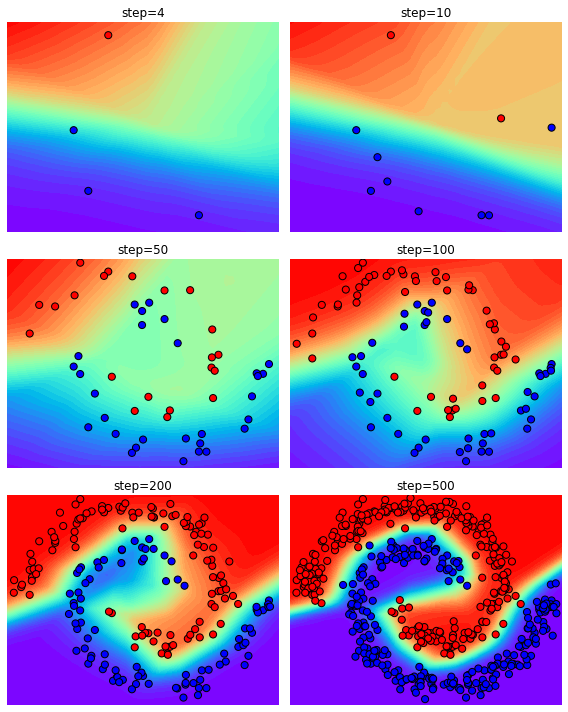

In [205]:
intermediate_steps = [3, 9, 49, 99, 199, num_per_class*2-1]
fig, ax = plt.subplots(3, 2, figsize=(8, 10))
for step, axi in zip(intermediate_steps, ax.flatten()):
    Zi = posterior_predictive_grid(input_grid_nc, fcekf_weights_nc[step], sigmoid_fn_nc, binary=False)
    title = f'step={step+1}'
    plot_posterior_predictive(axi, X_nc[:step+1], Y_nc[:step+1], title, input_grid_nc, Zi)
plt.tight_layout()

## 5.3 Fully-Decoupled Diagonal EKF

In [222]:
# Define MLP architecture
input_dim_nc, hidden_dims_nc, output_dim_nc = 2, [25, 25], 1
model_dims_nc = [input_dim_nc, *hidden_dims_nc, output_dim_nc]
_, flat_params_nc, _, apply_fn_nc = get_mlp_flattened_params(model_dims_nc)
state_dim_nc, emission_dim_nc = flat_params_nc.size, output_dim_nc
print(flat_params_nc.shape)

(751,)


In [223]:
# DEKF for nonlinear classification
dekf_params_nc = DEKFParams(
    initial_mean=flat_params_nc,
    initial_cov_diag=jnp.ones((state_dim_nc,)),
    dynamics_cov_diag=jnp.ones((state_dim_nc,)) * 1e-4,
    emission_mean_function = lambda w, x: sigmoid_fn_nc(w, x),
    emission_cov_function = lambda w, x: sigmoid_fn_nc(w, x) * (1 - sigmoid_fn_nc(w, x))
)

In [224]:
fdekf_post_nc = stationary_dynamics_fully_decoupled_conditional_moments_gaussian_filter(dekf_params_nc, Y_nc, inputs=X_nc)
fdekf_weights_nc = fdekf_post_nc.filtered_means
fdekf_covs_nc = fdekf_post_nc.filtered_covariances
fdekf_weight_nc = fdekf_weights_nc[-1]
fdekf_cov_nc = fdekf_covs_nc[-1]

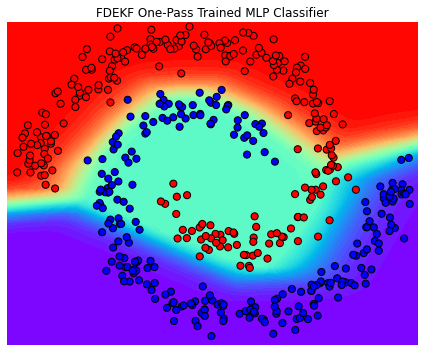

In [230]:
# Evaluate the trained MLP on grid and plot
Z_fdekf_nc = posterior_predictive_grid(input_grid_nc, fdekf_weight_nc, sigmoid_fn_nc, binary=False)
fig, ax = plt.subplots(figsize=(6, 5))
title = "FDEKF One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_nc, Y_nc, title, input_grid_nc, Z_fdekf_nc);

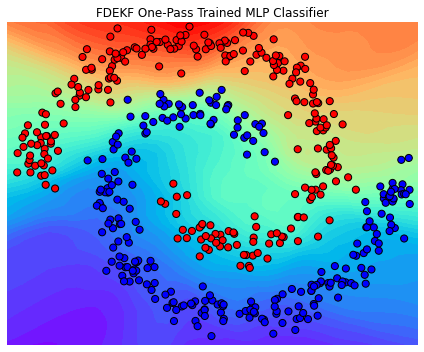

In [235]:
# Evaluate the trained MLP on grid and plot
Z_fdekf_nc_laplace = posterior_predictive_grid_ekf(input_grid_nc, fdekf_weight_nc, 
                                                   fdekf_cov_nc, sigmoid_fn_nc, binary=False,
                                                   ekf_type='fdekf')
fig, ax = plt.subplots(figsize=(6, 5))
title = "FDEKF One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_nc, Y_nc, title, input_grid_nc, Z_fdekf_nc_laplace);

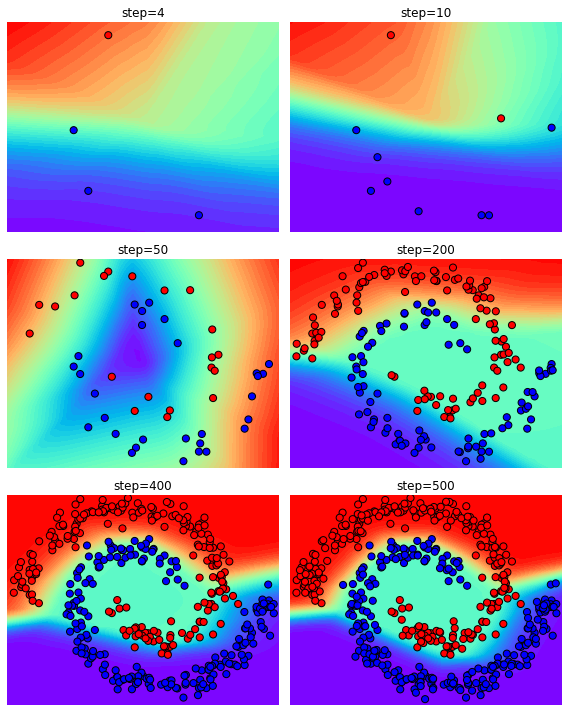

In [226]:
intermediate_steps = [3, 9, 49, 199, 399, num_per_class*2-1]
fig, ax = plt.subplots(3, 2, figsize=(8, 10))
for step, axi in zip(intermediate_steps, ax.flatten()):
    Zi = posterior_predictive_grid(input_grid_nc, fdekf_weights_nc[step], sigmoid_fn_nc, binary=False)
    title = f'step={step+1}'
    plot_posterior_predictive(axi, X_nc[:step+1], Y_nc[:step+1], title, input_grid_nc, Zi)
plt.tight_layout()

## 5.4 Variational Diagonal EKF

In [227]:
# VDEKF for nonlinear classification
vdekf_params_nc = DEKFParams(
    initial_mean=flat_params_nc,
    initial_cov_diag=jnp.ones((state_dim_nc,)) * 5e-1,
    dynamics_cov_diag=jnp.ones((state_dim_nc,)) * 1e-4,
    emission_mean_function = lambda w, x: sigmoid_fn_nc(w, x),
    emission_cov_function = lambda w, x: sigmoid_fn_nc(w, x) * (1 - sigmoid_fn_nc(w, x))
)

In [228]:
vdekf_post_nc = stationary_dynamics_variational_diagonal_extended_kalman_filter(vdekf_params_nc, Y_nc, inputs=X_nc)
vdekf_weights_nc = vdekf_post_nc.filtered_means
vdekf_covs_nc = vdekf_post_nc.filtered_covariances
vdekf_weight_nc = vdekf_weights_nc[-1]
vdekf_cov_nc = vdekf_covs_nc[-1]

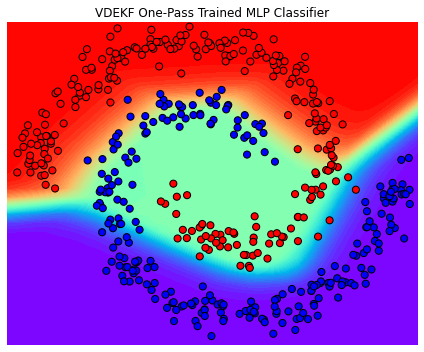

In [237]:
# Evaluate the trained MLP on grid and plot
Z_vdekf_nc = posterior_predictive_grid(input_grid_nc, vdekf_weight_nc, sigmoid_fn_nc, binary=False)
fig, ax = plt.subplots(figsize=(6, 5))
title = "VDEKF One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_nc, Y_nc, title, input_grid_nc, Z_vdekf_nc);

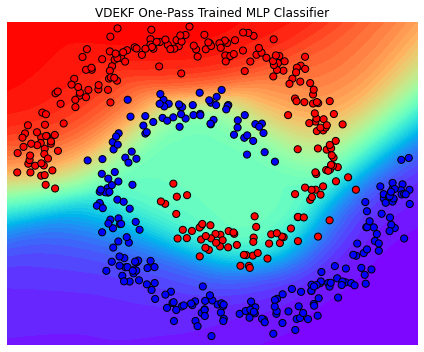

In [236]:
# Evaluate the trained MLP on grid and plot
Z_vdekf_nc_laplace = posterior_predictive_grid_ekf(input_grid_nc, vdekf_weight_nc, vdekf_cov_nc,
                                                   sigmoid_fn_nc, binary=False, ekf_type='vdekf')
fig, ax = plt.subplots(figsize=(6, 5))
title = "VDEKF One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_nc, Y_nc, title, input_grid_nc, Z_vdekf_nc_laplace);

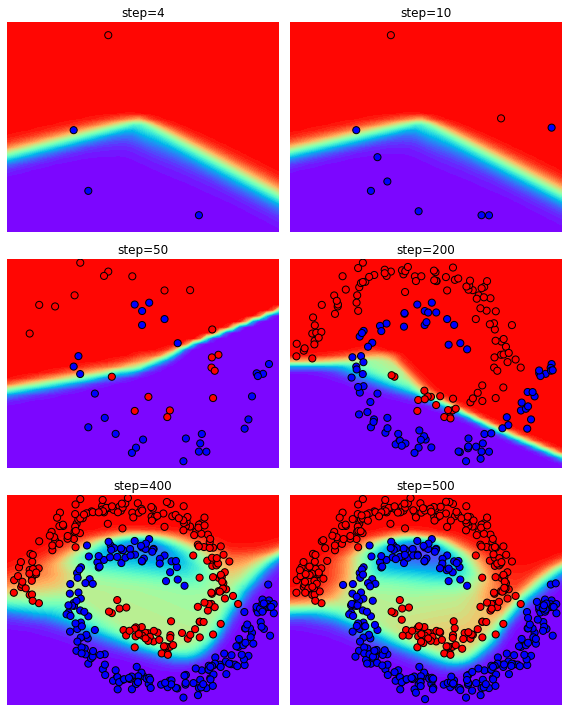

In [163]:
fig, ax = plt.subplots(3, 2, figsize=(8, 10))
for step, axi in zip(intermediate_steps, ax.flatten()):
    Zi = posterior_predictive_grid(input_grid_nc, vdekf_weights_nc[step], sigmoid_fn_nc, binary=False)
    title = f'step={step+1}'
    plot_posterior_predictive(axi, X_nc[:step+1], Y_nc[:step+1], title, input_grid_nc, Zi)
plt.tight_layout()

## 5.5 SGD - One Pass

In [252]:
# Cross entropy loss for nonlinear classification
loss_fn_nc = partial(loss_optax, loss_fn = lambda y, yhat: -(y * jnp.log(yhat) + (1-y) * jnp.log(1 - yhat)), 
                     apply_fn = sigmoid_fn_nc)

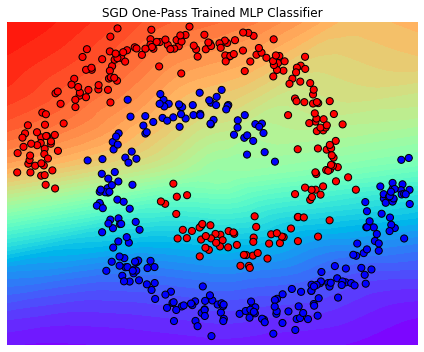

In [253]:
sgd_sp_nc = fit_optax(flat_params_nc, sgd_optimizer, X_nc, Y_nc, loss_fn_nc, num_epochs=1)

# Evaluate the trained MLP on grid and plot
Z_sgd_sp_nc = posterior_predictive_grid(input_grid_nc, sgd_sp_nc, sigmoid_fn_nc, binary=False)
fig, ax = plt.subplots(figsize=(6, 5))
title = "SGD One-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_nc, Y_nc, title, input_grid_nc, Z_sgd_sp_nc);

## 5.6 SGD - Multi Pass (200 Epochs)

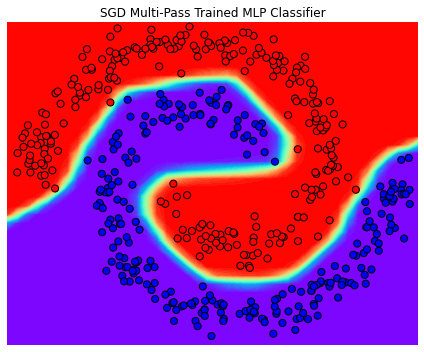

In [254]:
sgd_mp_nc = fit_optax(flat_params_nc, sgd_optimizer, X_nc, Y_nc, loss_fn_nc, num_epochs=200)

# Evaluate the trained MLP on grid and plot
Z_sgd_mp_nc = posterior_predictive_grid(input_grid_nc, sgd_mp_nc, sigmoid_fn_nc, binary=False)
fig, ax = plt.subplots(figsize=(6, 5))
title = "SGD Multi-Pass Trained MLP Classifier"
plot_posterior_predictive(ax, X_nc, Y_nc, title, input_grid_nc, Z_sgd_mp_nc);

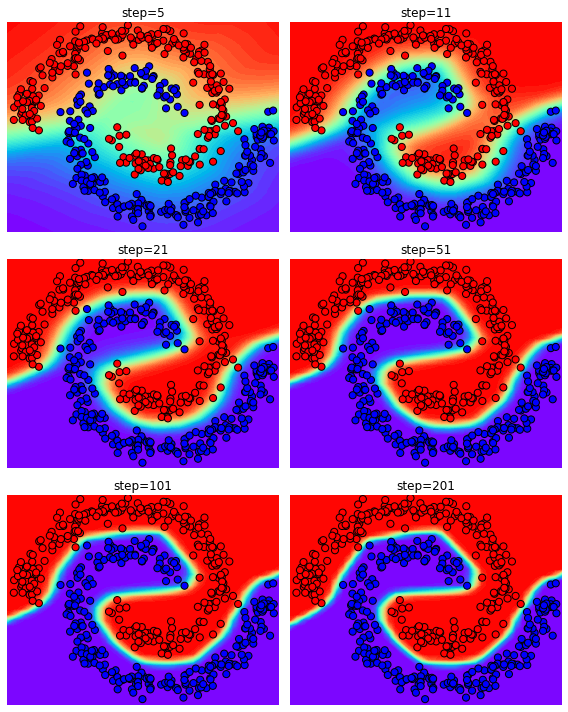

In [255]:
epoch_range = jnp.array([4, 10, 20, 50, 100, 200])
fig, ax = plt.subplots(3, 2, figsize=(8, 10))
for step, axi in zip(epoch_range, ax.flatten()):
    params_step = fit_optax(flat_params_nc, sgd_optimizer, X_nc, Y_nc, loss_fn_nc, num_epochs=step)
    Zi = posterior_predictive_grid(input_grid_nc, params_step, sigmoid_fn_nc, binary=False)
    title = f'step={step+1}'
    plot_posterior_predictive(axi, X_nc, Y_nc, title, input_grid_nc, Zi)
plt.tight_layout()

## 5.7 Model Comparison

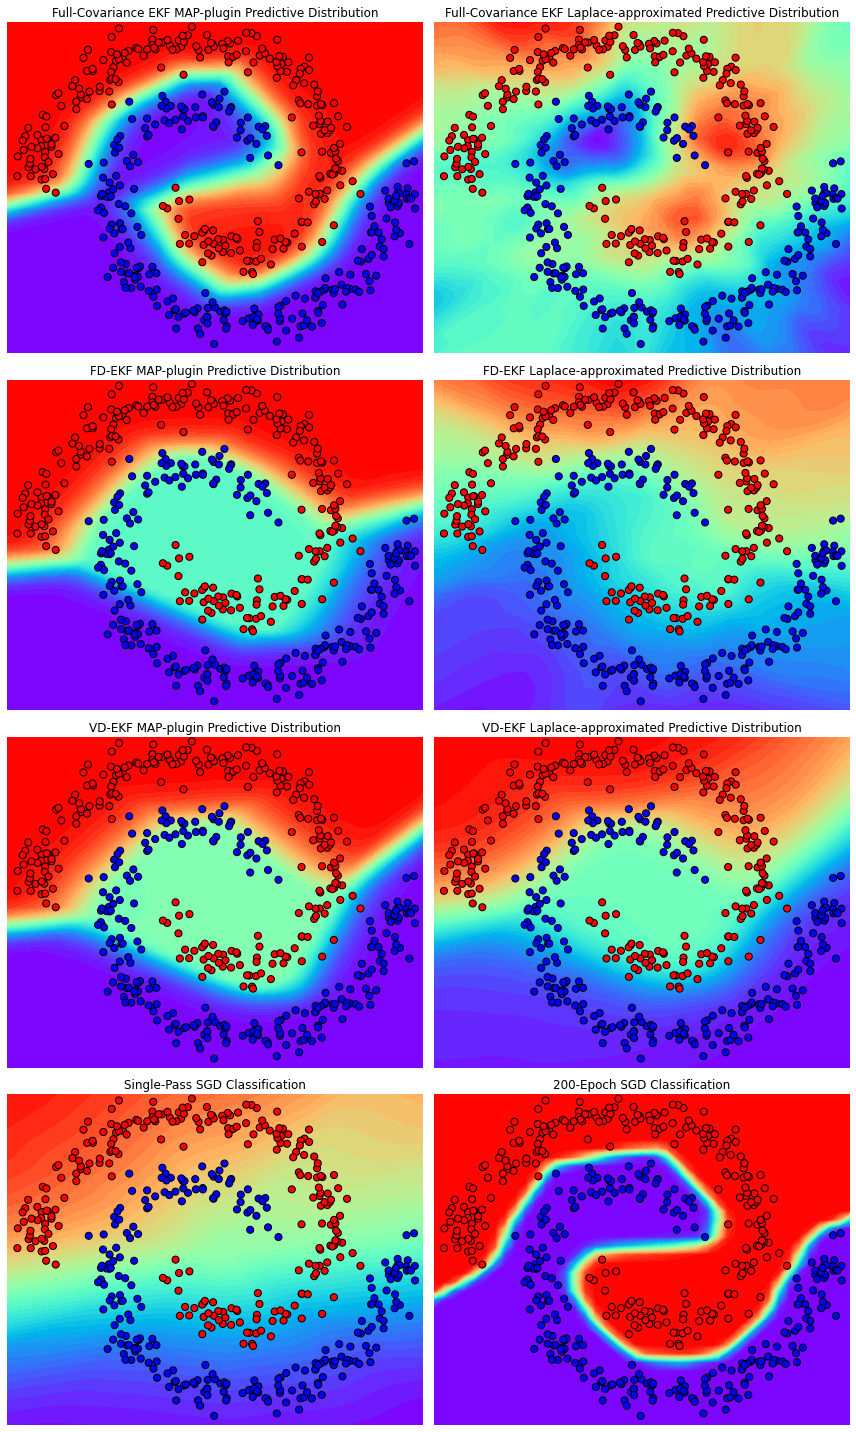

In [260]:
fig, axs = plt.subplots(4, 2, figsize=(12, 20))
title1 = "Full-Covariance EKF MAP-plugin Predictive Distribution"
plot_posterior_predictive(axs[0, 0], X_nc, Y_nc, title1, input_grid_nc, Z_fcekf_nc);
title2 = "Full-Covariance EKF Laplace-approximated Predictive Distribution"
plot_posterior_predictive(axs[0, 1], X_nc, Y_nc, title2, input_grid_nc, Z_fcekf_nc_laplace);
title3 = "FD-EKF MAP-plugin Predictive Distribution"
plot_posterior_predictive(axs[1, 0], X_nc, Y_nc, title3, input_grid_nc, Z_fdekf_nc);
title4 = "FD-EKF Laplace-approximated Predictive Distribution"
plot_posterior_predictive(axs[1, 1], X_nc, Y_nc, title4, input_grid_nc, Z_fdekf_nc_laplace);
title5 = "VD-EKF MAP-plugin Predictive Distribution"
plot_posterior_predictive(axs[2, 0], X_nc, Y_nc, title5, input_grid_nc, Z_vdekf_nc);
title6 = "VD-EKF Laplace-approximated Predictive Distribution"
plot_posterior_predictive(axs[2, 1], X_nc, Y_nc, title6, input_grid_nc, Z_vdekf_nc_laplace);
title7 = "Single-Pass SGD Classification"
plot_posterior_predictive(axs[3, 0], X_nc, Y_nc, title7, input_grid_nc, Z_sgd_sp_nc);
title8 = "200-Epoch SGD Classification"
plot_posterior_predictive(axs[3, 1], X_nc, Y_nc, title8, input_grid_nc, Z_sgd_mp_nc);
fig.savefig('halfmoon_comparison.jpg')